In [264]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
import cmasher as cmr
import seaborn as sns

In [265]:
import os
import glob
common_folder_path = r"C:\Users\kalos\Documents\PMoPA_files\DAQ\240709\fluorescence_backfill\BMdelay550"
bg_shotlist = glob.glob(common_folder_path + "\\" + r"bg\FluorescenceCam\*" + 'shot' + r"*")
#print(bg_shotlist)

pressures = [6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80]


C:\Users\kalos\AppData\Local\Temp\ipykernel_22676\3655624502.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,2, figsize=(10,3))


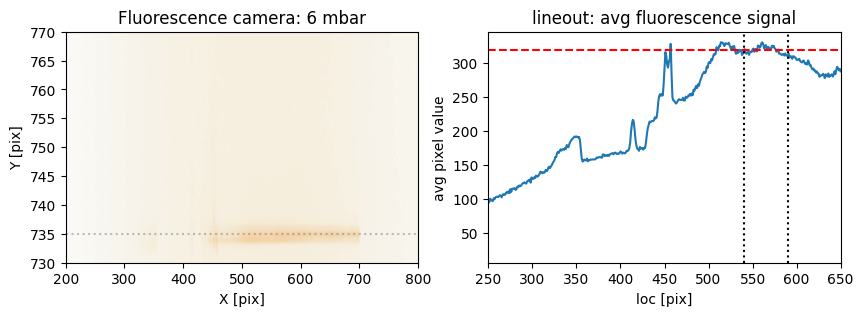

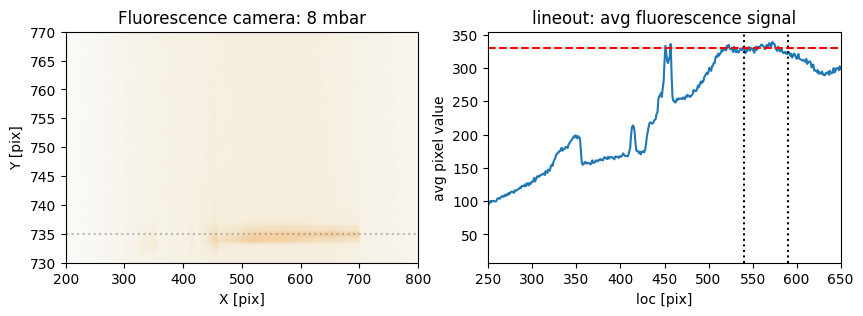

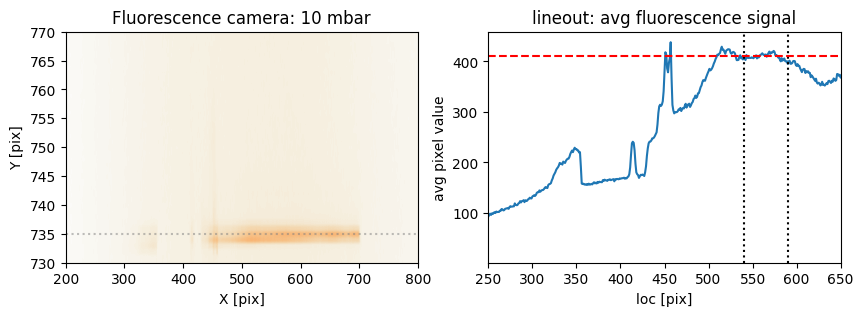

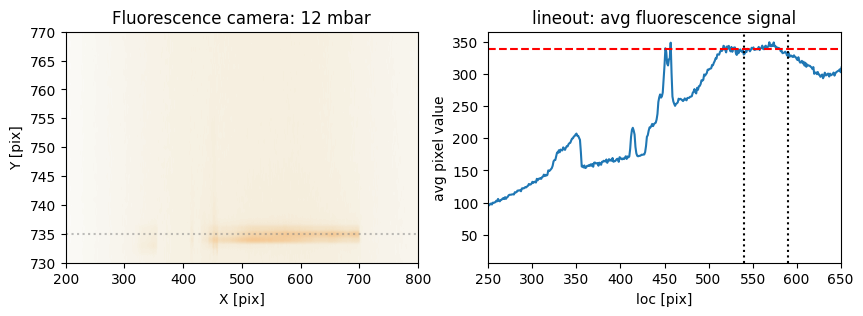

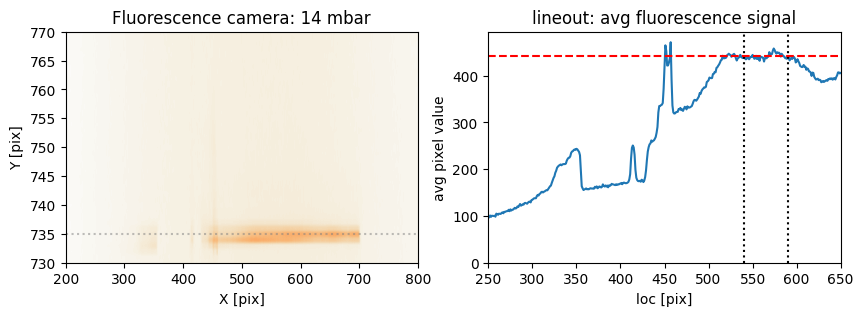

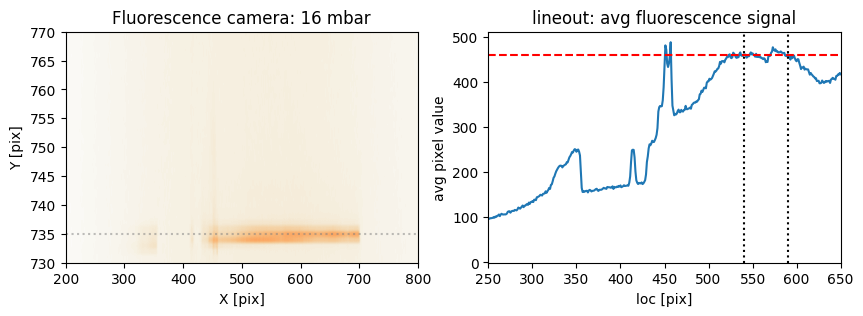

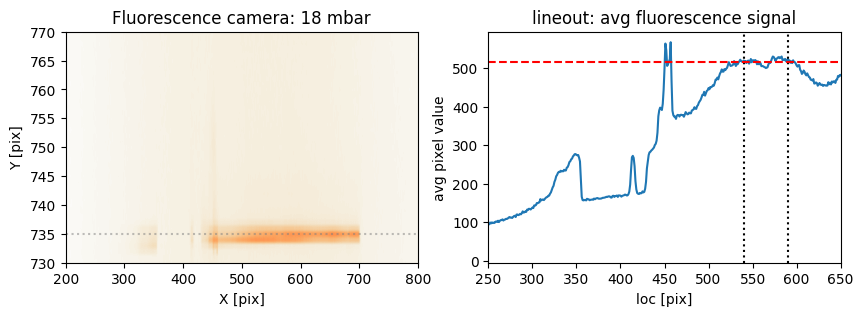

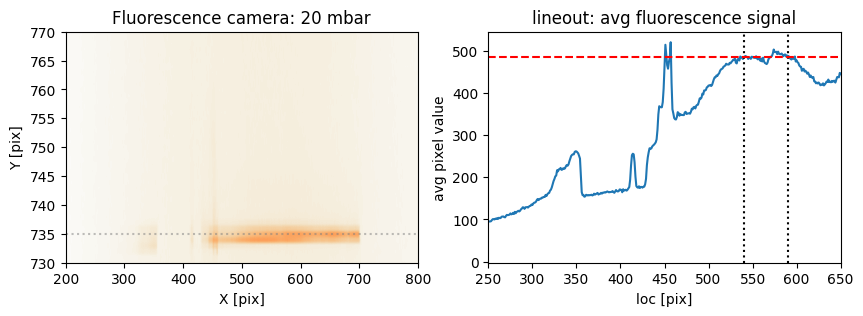

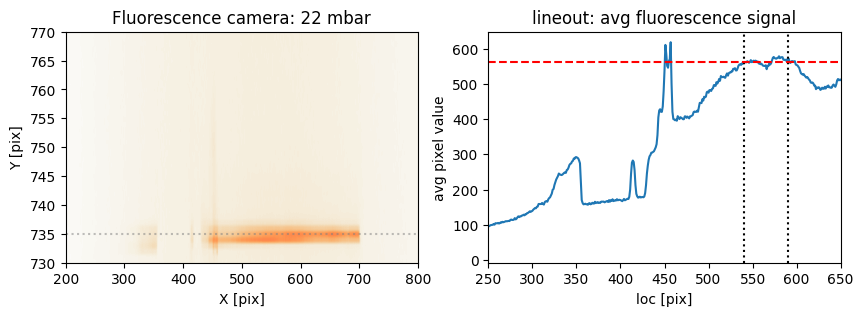

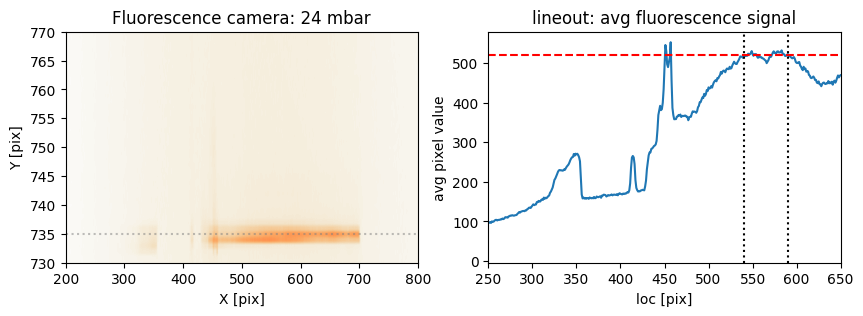

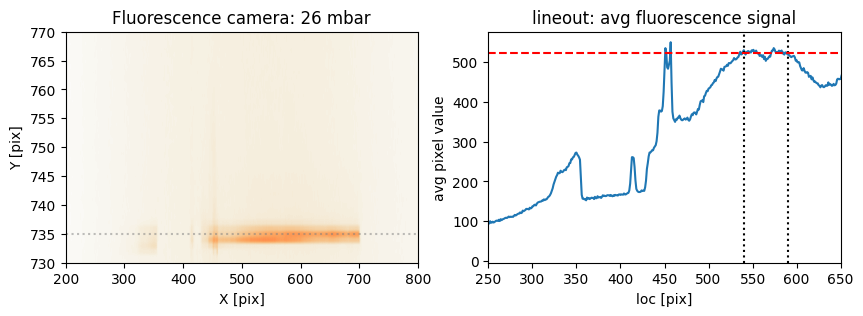

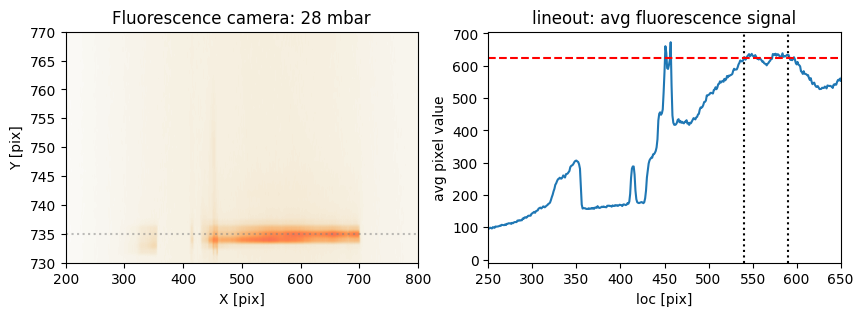

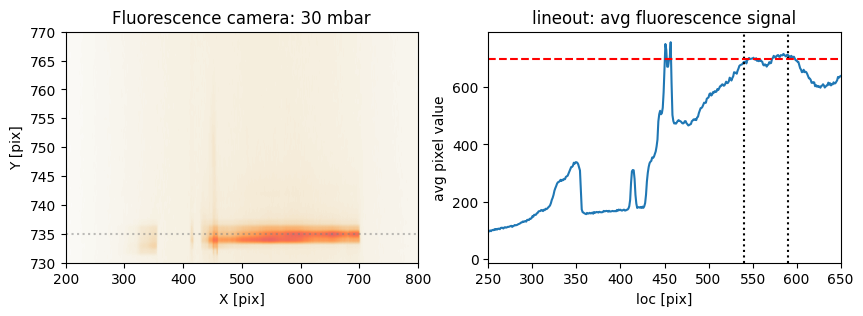

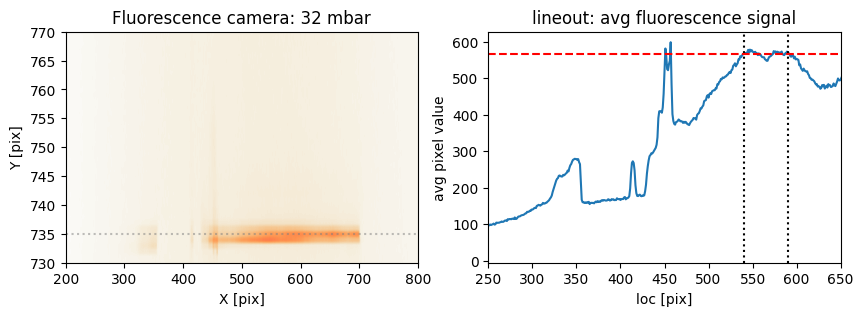

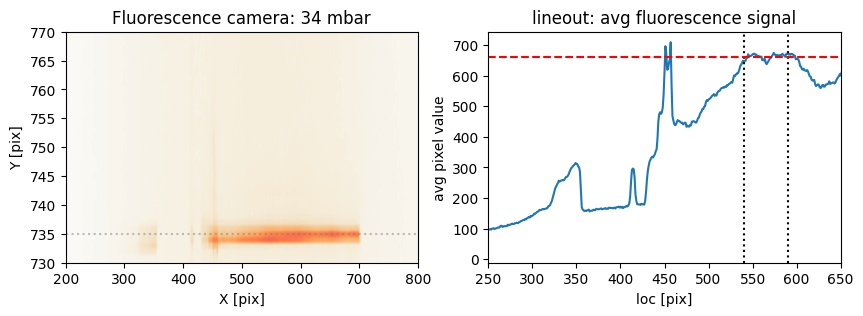

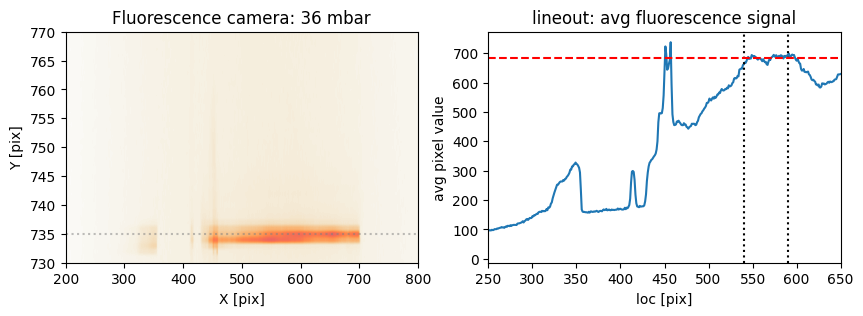

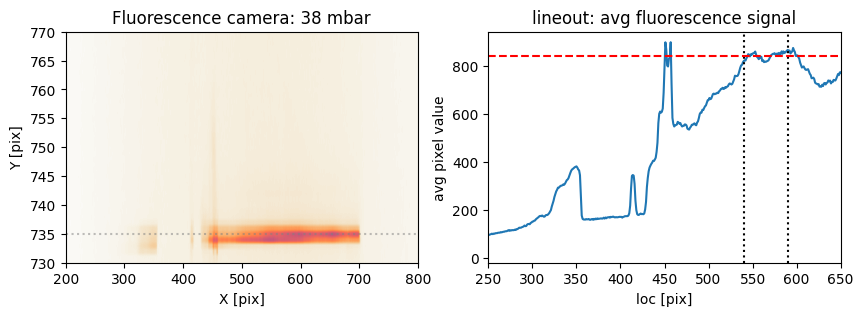

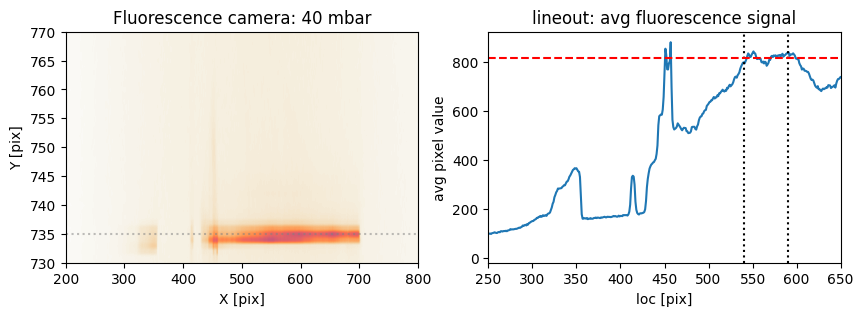

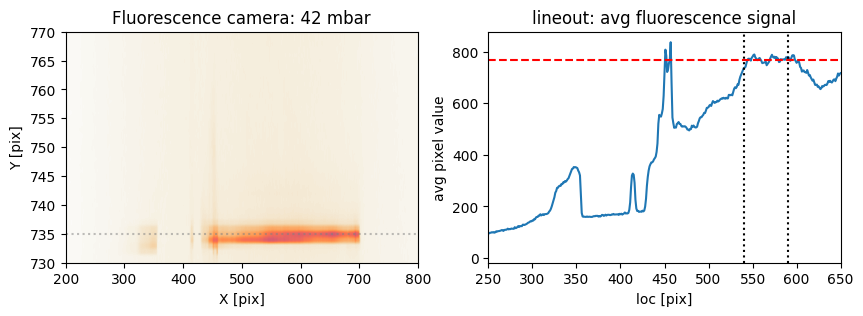

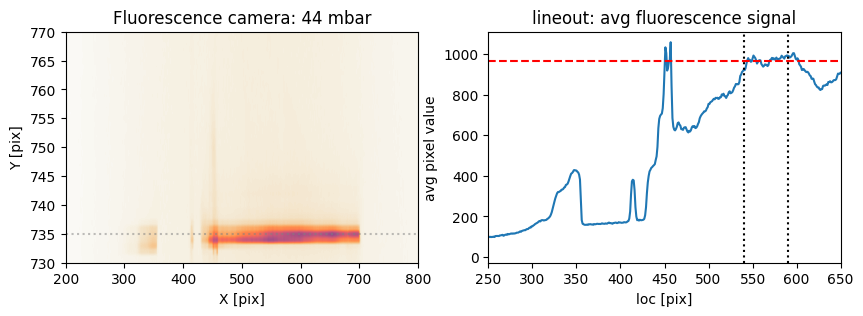

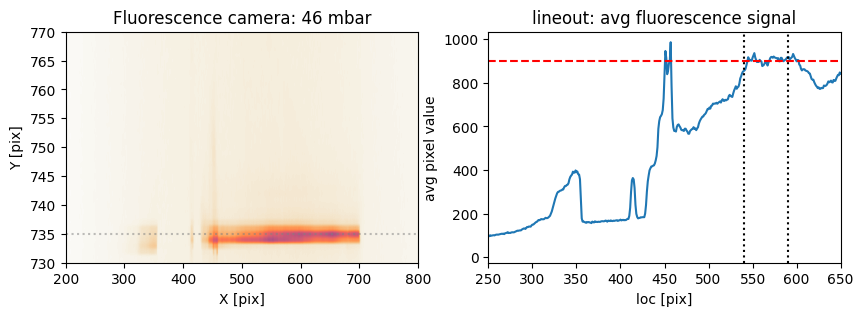

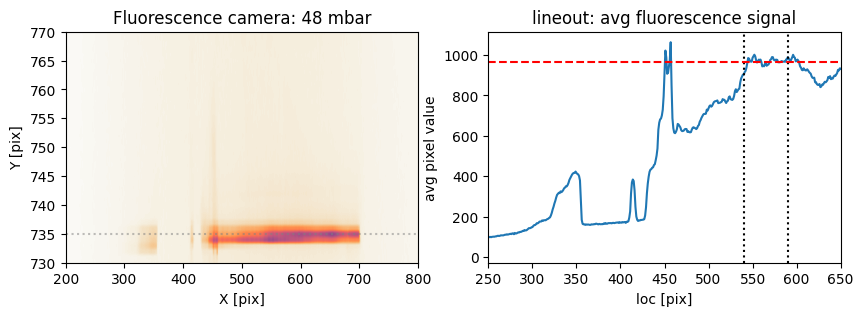

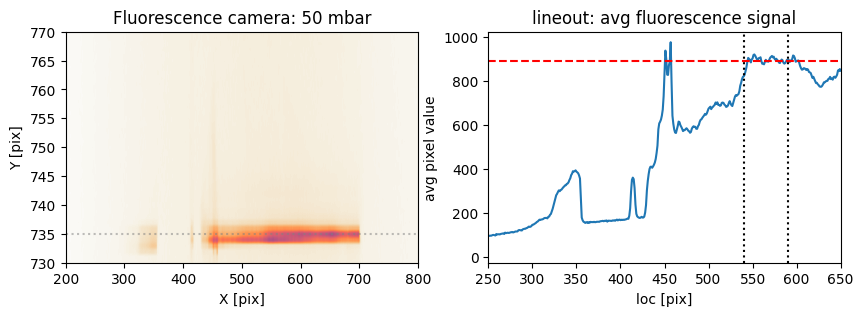

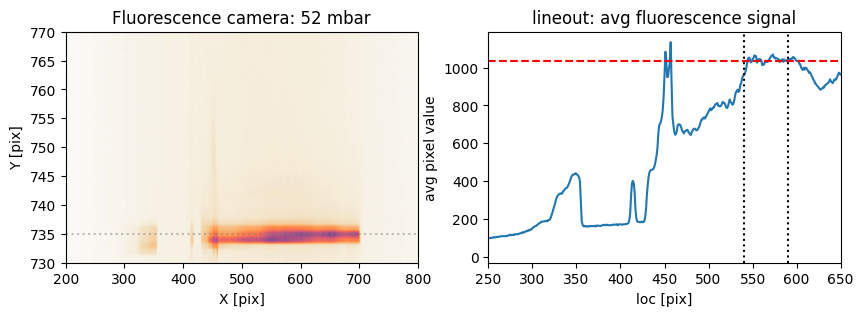

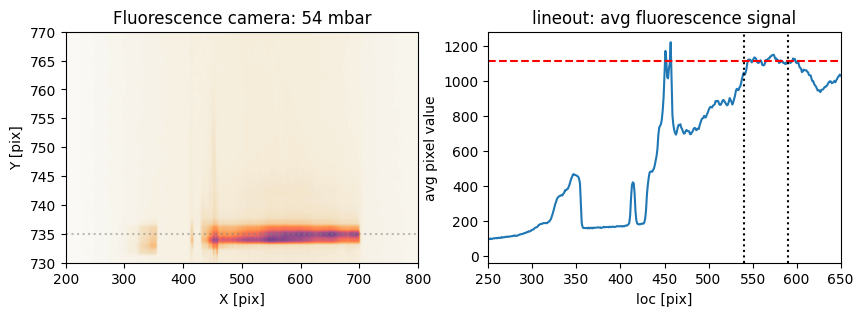

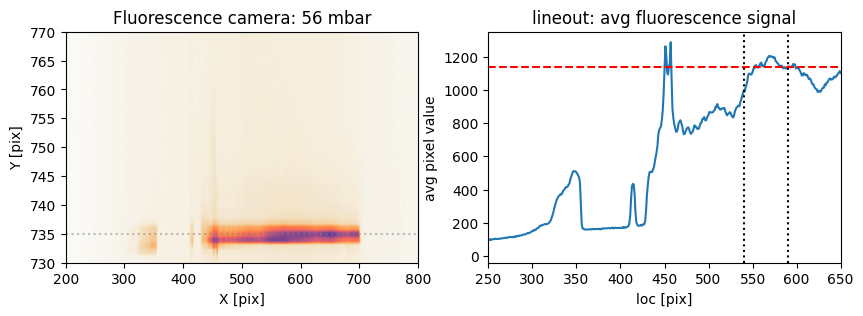

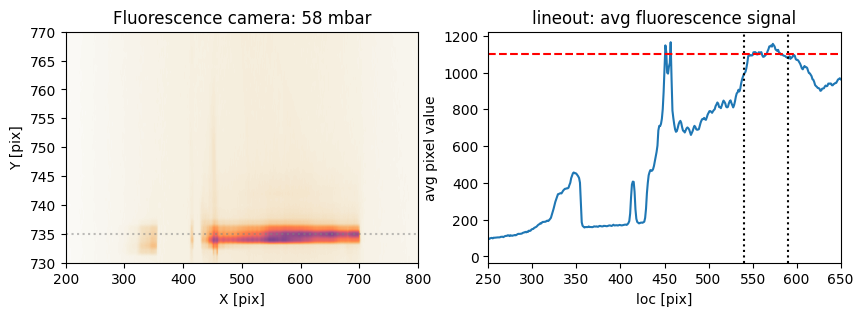

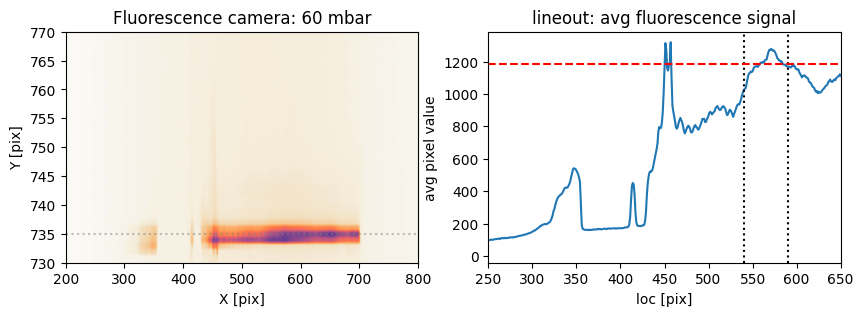

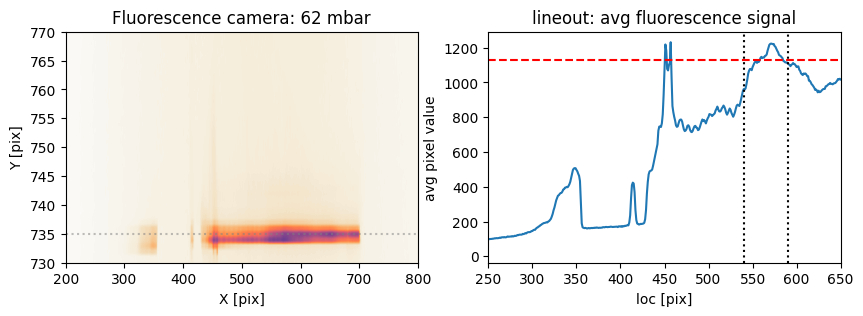

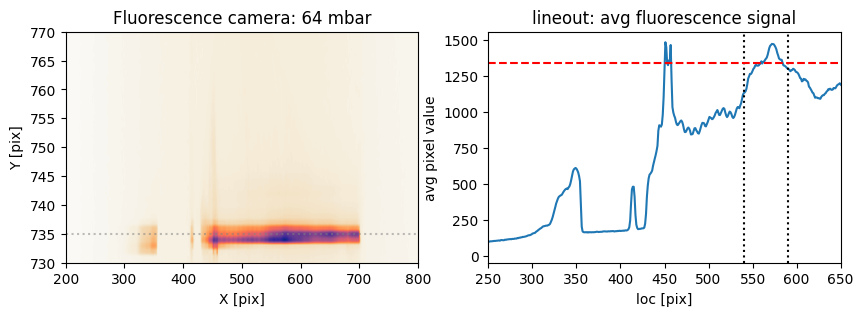

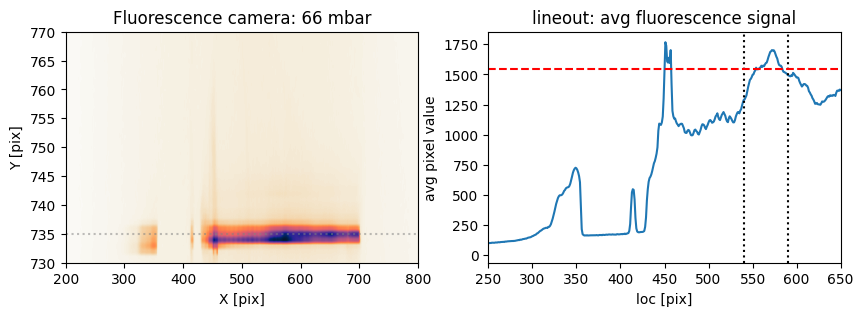

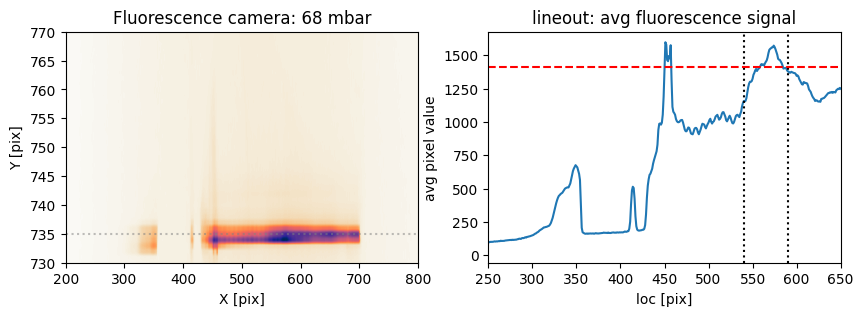

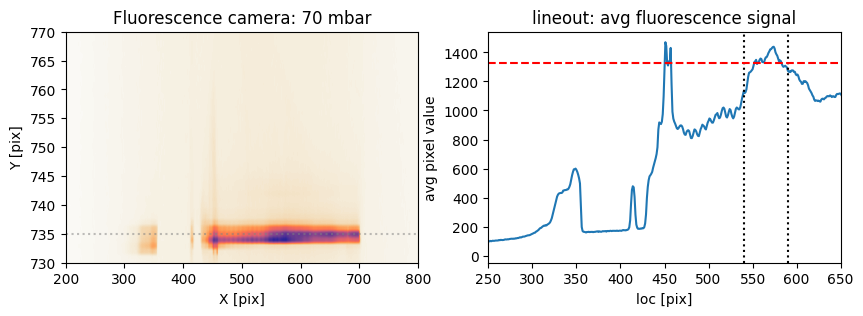

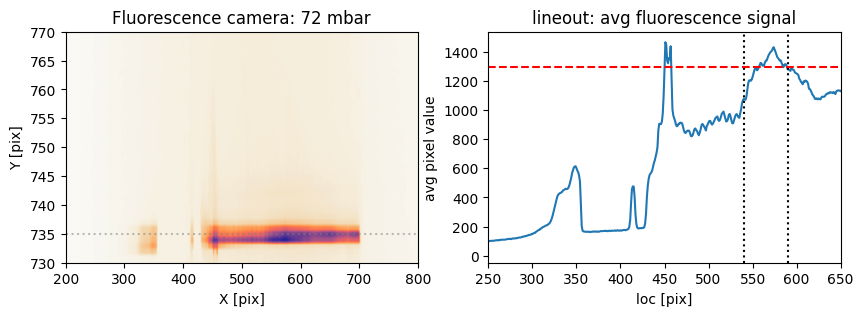

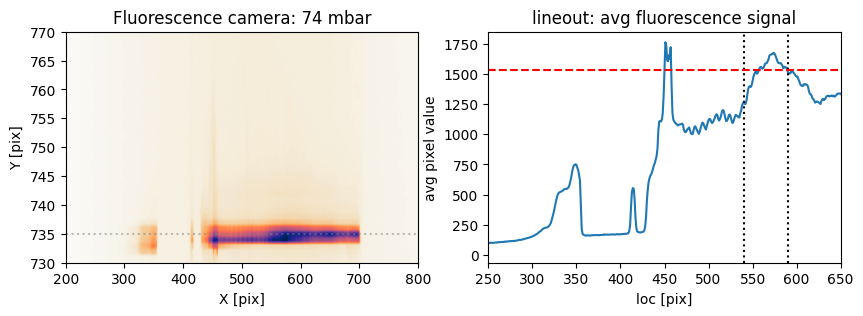

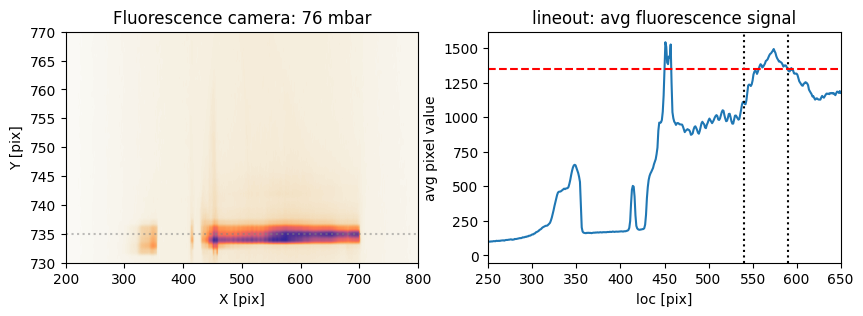

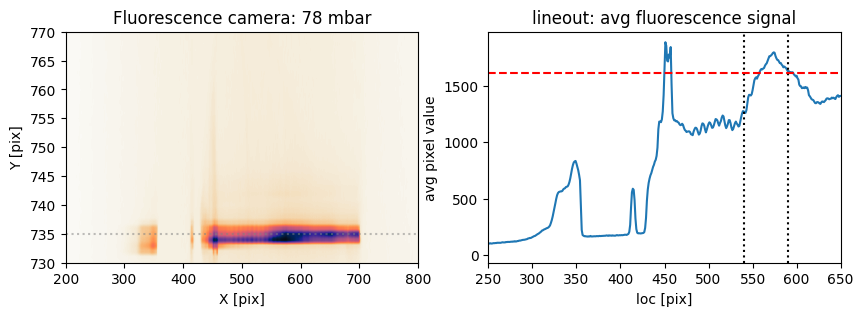

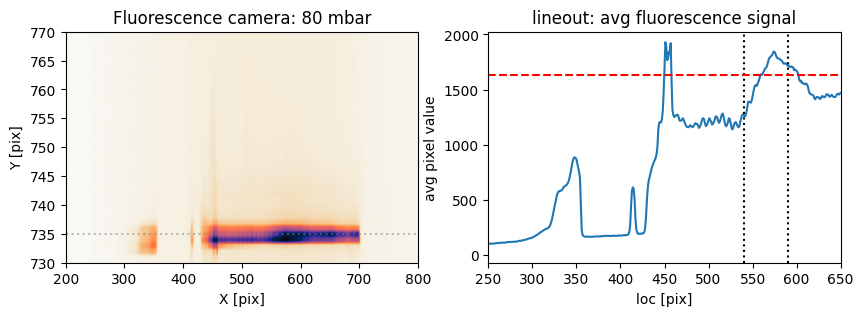

In [266]:
avg_sigs = np.zeros(len(pressures))
#avg_sigs_fri = np.zeros(len(pressures))

def load_and_calculate_average(filenames):
    # Initialize an empty array to store pixel values
    total_sum = None
    # Iterate over each filename
    for filename in filenames:
        # Load the image
        image = cv2.imread(filename, -1)
        # If this is the first image, initialize total_sum with zeros
        if total_sum is None:
            total_sum = np.zeros_like(image, dtype=np.uint64)
        # Add the pixel values of the current image to the total_sum
        total_sum += image.astype(np.uint64)
    # Calculate the average pixel value
    average_image = total_sum / len(filenames)
    return average_image

def get_avg_signal(shotlist,bg_shotlist,plot_flag, title):

    if len(shotlist) == 0:
        return 0
    else:
        average_image = load_and_calculate_average(shotlist)
        average_image_bg = load_and_calculate_average(bg_shotlist)

        im = average_image - average_image_bg 
        im[im<0] = 0

        lineoutIdx = 735
        start = 540
        stop = 590
        d = 3
        lineout = np.mean(im[lineoutIdx-d:lineoutIdx+d,:], axis=0)
        avg_sig = np.mean(lineout[start:stop])

        if plot_flag:
            fig, axs = plt.subplots(1,2, figsize=(10,3))
            axs[0].imshow(im, aspect='auto', origin='lower', vmin=0, vmax=2**12, cmap=cmr.torch_r)
            axs[0].axhline(lineoutIdx, ls=':', color=[0.5,0.5,0.5,0.5])
            axs[0].set_xlim(200, 800)
            axs[0].set_ylim(730, 770)
            axs[0].set_xlabel('X [pix]')
            axs[0].set_ylabel('Y [pix]')

            axs[1].plot(lineout)
            axs[1].set_xlim(250, 650)
            
            axs[1].axvline(start,ls='dotted',color='black')
            axs[1].axvline(stop,ls='dotted',color='black')
            axs[1].set_title('lineout: avg fluorescence signal')
            axs[1].set_xlabel('loc [pix]')
            axs[1].set_ylabel('avg pixel value')


            axs[1].axhline(avg_sig,color='red',ls='dashed')
            axs[0].set_title('Fluorescence camera: '+title)
        return avg_sig


for pressure,i in zip(pressures,range(len(pressures))):
    shotlist = glob.glob(common_folder_path + "\\" +str(pressure) + r"mbar\FluorescenceCam\*" + 'shot' + r"*")
    avg_sigs[i] = get_avg_signal(shotlist,bg_shotlist,plot_flag=True, title=str(pressure)+ " mbar")

[ 318.79242424  329.54757576  409.7830303   339.01939394  441.71181818
  459.61272727  516.47        485.30818182  563.24121212  519.46
  521.67939394  625.09878788  697.35424242  566.51909091  662.19090909
  682.47363636  842.72606061  816.46666667  768.70151515  966.88545455
  901.90606061  966.20454545  892.21969697 1036.37060606 1111.02606061
 1136.69454545 1098.94909091 1183.49359307 1128.97470418 1334.18121212
 1544.88406926 1408.8558153  1324.26248196 1296.54867244 1528.57105339
 1348.53327561 1610.18327561 1627.71327561]


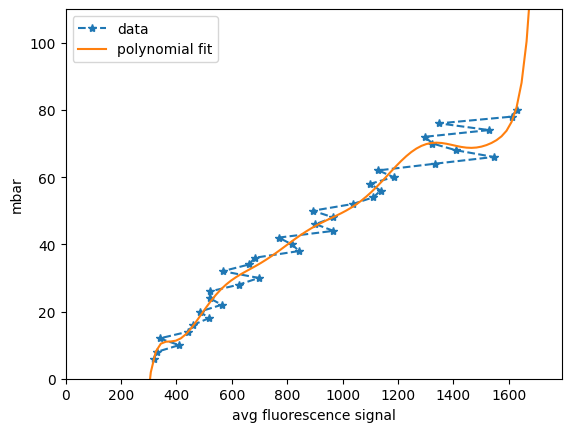

In [267]:
print(avg_sigs)

plt.plot(avg_sigs,pressures, '--*',label='data')
plt.ylabel('mbar')
plt.xlabel('avg fluorescence signal')

plt.xlim(0,1.1*max(avg_sigs))

mbar_per_sig = np.dot(avg_sigs,pressures) / np.dot(avg_sigs,avg_sigs)

xfit = np.linspace(0,1.1*max(avg_sigs),100)
yfit = mbar_per_sig*xfit

coeffs = np.polyfit(avg_sigs,pressures,11)
poly_func = np.poly1d(coeffs)


#plt.plot(xfit,yfit,label='fit')
plt.plot(xfit,poly_func(xfit),label='polynomial fit')
plt.ylim(0,110)

plt.legend()

In [268]:
iota_delays = [976,978,979,980,982,984,986,988,990,992,993,994,995,996,997,998,999]
iota_open_ms = [1,2,3,5,7] #opening times of the iota gas jet [ms]
iota_BPs = [6,8]

results_cube = np.zeros((len(iota_delays), len(iota_open_ms), len(iota_BPs))) #create an empty 3D array which will contain the data


for iota_delay,i in zip(iota_delays,range(len(iota_delays))):
    for iota_open_time, j in zip(iota_open_ms, range(len(iota_open_ms))):
        for iota_BP, k in zip(iota_BPs, range(len(iota_BPs))):
            shotlist = glob.glob(common_folder_path + "\\jet" + str (iota_open_time)+ "ms" +str(iota_delay) + r"del"+str(iota_BP)+"bar\FluorescenceCam\*" + 'shot' + r"*")
            p=iota_delays.index(iota_delay)
            q=iota_open_ms.index(iota_open_time)
            r=iota_BPs.index(iota_BP)
            results_cube[p,q,r] = get_avg_signal(shotlist,bg_shotlist,plot_flag=False, title=str(iota_delay)+ ", jet "+str(iota_open_time)+ " ms "+str(iota_BP)+" bar")

0.0
69.13612318048399


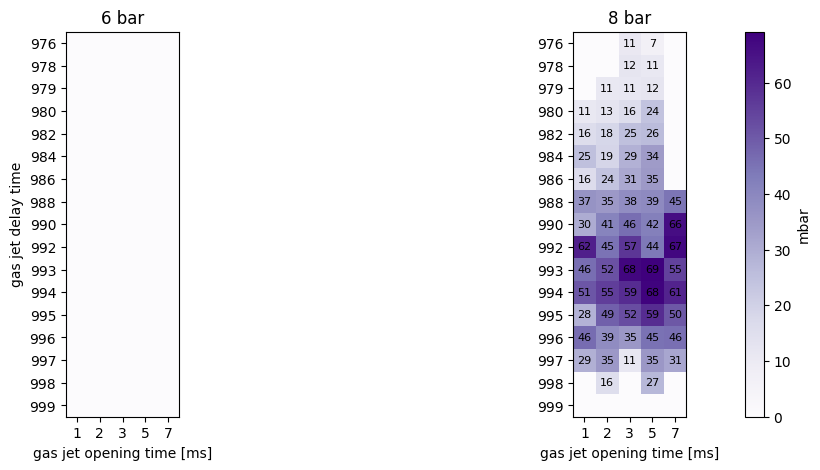

In [ ]:
# Create a sample 3D array of values
array_3d = np.vectorize(poly_func)(results_cube)
array_3d=array_3d.clip(min=0)

min_value = np.min(array_3d)
max_value = np.max(array_3d)

print(min_value)
print(max_value)

# Create subplots for each 2D slice
fig, axs = plt.subplots(1, array_3d.shape[2], figsize=(15, 5))  # Adjust figsize as needed

cmap = "Purples"
# Plot each 2D slice
for i in range(array_3d.shape[2]):
    axs[i].imshow(array_3d[:, :, i], cmap=cmap, vmin=min_value, vmax=max_value)  # You can use any colormap you prefer
    axs[i].set_title(f"{iota_BPs[i]} bar")
    #axs[i].axis('off')  # Hide axis labels

    # Add text annotations
    for y in range(array_3d.shape[0]):
        for x in range(array_3d.shape[1]):
            if array_3d[y, x, i] > 0.1:
                axs[i].text(x, y, f'{array_3d[y, x, i]:.0f}', color='black', ha='center', va='center',fontsize=8)
    

    axs[i].set_xticks(np.arange(array_3d.shape[1]))
    axs[i].set_xticklabels(iota_open_ms)
    axs[i].set_yticks(np.arange(array_3d.shape[0]))
    axs[i].set_yticklabels(iota_delays)

    axs[i].set_xlabel('gas jet opening time [ms]')

axs[0].set_ylabel('gas jet delay time')

# Add color bar
cbar = fig.colorbar(axs[-1].imshow(array_3d[:, :, -1], cmap=cmap), ax=axs.ravel().tolist())
cbar.set_label('mbar')
